<a href="https://www.kaggle.com/code/stauro/lmage-search-w-autoencoder-nearest-neighbour?scriptVersionId=127558919" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Hyperparameters
batch_size = 128 # How many independent images should we process in parallel.
n_hidden = 128 # Define the number of hidden layers in dense neural net layer.
max_iters = 10000 # Number of training iterations of the model.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# load data
df = pd.read_csv("/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv")
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# input(X) and output labels(y)

# Dividing by 255 to normalize the data bring to the range(0, 1)
X=df.drop(['names','labels'],axis=1).values.reshape(df.shape[0], 1, 28, 28) / 255
y=df['labels']

In [6]:
chars = sorted(list(df['labels'].unique()))
vocab_size = len(chars) # Number of unique characters in the input.

itos = {i:ch for i,ch in enumerate(chars)}
stoi = {ch:i for i,ch in enumerate(chars)}

# Map the labels for string to integer.
y_upd = np.array([stoi[ch] for ch in y])

print(vocab_size)

94


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_upd, test_size = 0.2, random_state = 1337)

In [8]:
# Convert the data to torch tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

# Convert the label data to one hot encoding vectors.
y_train_one_hot = F.one_hot(torch.from_numpy(y_train), num_classes=vocab_size)
y_test_one_hot = F.one_hot(torch.from_numpy(y_test), num_classes=vocab_size)

In [9]:
# Get batch_size rows of train/test data for their respective purposes.
def get_batch(split, batch_size=128):
    X_c = X_train if split == "train" else X_test
    y_c = y_train_one_hot if split == "train" else y_test_one_hot
    ix = torch.randint(len(X_c), (batch_size, ))
    x_batch = torch.tensor(torch.stack([X_c[i] for i in ix], dim=0), dtype=torch.float32)
    y_batch = torch.tensor(torch.stack([y_c[i] for i in ix], dim=0), dtype=torch.float32)
    return x_batch.to(device), y_batch.to(device)

In [10]:
# Estimate the loss of the model on a small slice of test set(batch_size(256) rows).
@torch.no_grad()
def estimate_loss():
    correct = 0
    model.eval()
    x_t, _ = get_batch("test", batch_size=256)
    out = model(x_t)
    loss = F.l1_loss(out, x_t, reduction='mean') # MAE loss
    model.train()
    return loss.item()

In [11]:
## CREATE AN AUTOENCODER ##

class Encoder(nn.Module):
    """ Convolutional neural network that acts as an encoder"""
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2,stride=2), # (B, 1, 28, 28) --> (B, 32, 14, 14)
            nn.ReLU(), # (B, 32, 26, 26) --> (B, 32, 26, 26)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2), # (B, 32, 14, 14) --> (B, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2), # (B, 64, 7, 7) --> (B, 128, 3, 3)
            nn.ReLU(),
            nn.Flatten(start_dim=1, end_dim=-1), # (B, 128, 3, 3) --> (B, 128 * 3 * 3)
            nn.Linear(128 * 3 * 3, 128 * 3), 
            nn.BatchNorm1d(128 * 3), 
            nn.ReLU(), 
            nn.Linear(128 * 3, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.net(x)
    

class Decoder(nn.Module):
    """ Convolutional neural network that acts as an decoder"""

    def __init__(self, encoder):
        super().__init__()
        self.net = nn.Sequential(
            encoder,
            nn.Linear(128, 128 * 3),
            nn.BatchNorm1d(128 * 3),
            nn.ReLU(),
            nn.Linear(128 * 3, 128 * 3 * 3),
            nn.BatchNorm1d(128 * 3 * 3),
            nn.ReLU(),
            nn.Unflatten(1, (128, 3, 3)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


    
encoder = Encoder().to(device)
model = Decoder(encoder).to(device)
model = model.to(device)

In [12]:
xb, _ = get_batch("train")
print(model(xb).shape)

num_params = sum(p.nelement() for p in model.parameters())

print(num_params)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


torch.Size([128, 1, 28, 28])
1112641


In [13]:
## Training the model ##
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

for i in range(11001):
    xb, yb = get_batch("train")
    recon_image = model(xb)
    loss = F.l1_loss(recon_image, xb, reduction='mean')
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if (i % 500 == 0):
        val_loss = estimate_loss()
        print(f"step: {i}, train loss: {loss.item():.4f}, val loss: {val_loss:.4f}")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


step: 0, train loss: 0.4226, val loss: 0.4129
step: 500, train loss: 0.0582, val loss: 0.0559
step: 1000, train loss: 0.0531, val loss: 0.0485
step: 1500, train loss: 0.0501, val loss: 0.0477
step: 2000, train loss: 0.0504, val loss: 0.0471
step: 2500, train loss: 0.0433, val loss: 0.0464
step: 3000, train loss: 0.0433, val loss: 0.0421
step: 3500, train loss: 0.0445, val loss: 0.0425
step: 4000, train loss: 0.0393, val loss: 0.0433
step: 4500, train loss: 0.0436, val loss: 0.0442
step: 5000, train loss: 0.0465, val loss: 0.0419
step: 5500, train loss: 0.0455, val loss: 0.0421
step: 6000, train loss: 0.0448, val loss: 0.0425
step: 6500, train loss: 0.0441, val loss: 0.0401
step: 7000, train loss: 0.0440, val loss: 0.0431
step: 7500, train loss: 0.0432, val loss: 0.0392
step: 8000, train loss: 0.0441, val loss: 0.0415
step: 8500, train loss: 0.0440, val loss: 0.0414
step: 9000, train loss: 0.0399, val loss: 0.0391
step: 9500, train loss: 0.0451, val loss: 0.0404
step: 10000, train loss:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


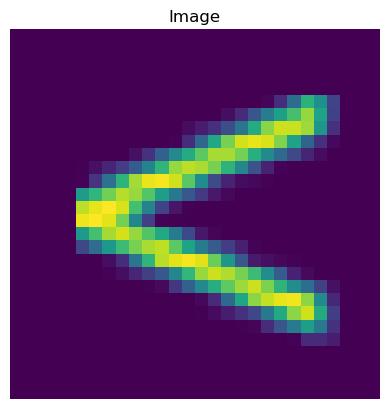

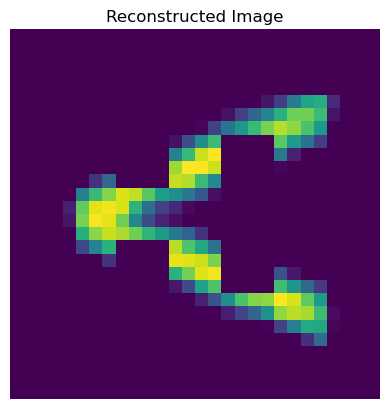

In [14]:
xb, _ = get_batch("train")
plt.imshow(xb[0][0].cpu().detach().numpy().reshape(28,28))
plt.title("Image")
plt.axis("off")
plt.savefig('graph.png')
plt.show()

out = model(xb)
plt.imshow(out[0][0].cpu().detach().numpy().reshape(28,28))
plt.title("Reconstructed Image")
plt.axis("off")
plt.savefig('graph.png')
plt.show()

In [15]:
def plotFoundImages(image):
    fig, axes = plt.subplots(nrows=image.shape[0] // 2, ncols=2)

    images = image.cpu().detach().numpy().reshape(image.shape[0], 28,28)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
    plt.show()
    
def plot(image, title):
    plt.imshow(image.cpu().detach().numpy().reshape(28,28))
    plt.title(title)
    plt.axis("off")
    plt.savefig('graph.png')
    plt.show()

In [16]:
emb_dataset = encoder(X_train[0:70000].to(device=device, dtype=torch.float32))

# Find the Top K(6) nearest neighbours.
def NearestNeighbours(query_emb):
    similarity_array = F.cosine_similarity(query_emb, emb_dataset, dim=1)
    values, indices = torch.topk(similarity_array, 6)
    plotFoundImages(X_train[indices.cpu()])

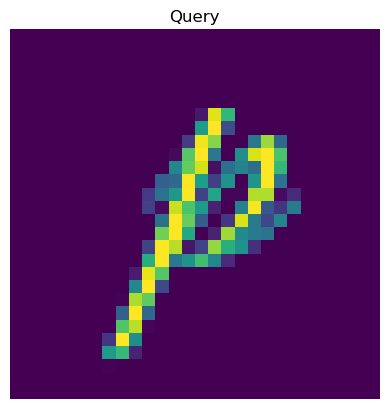

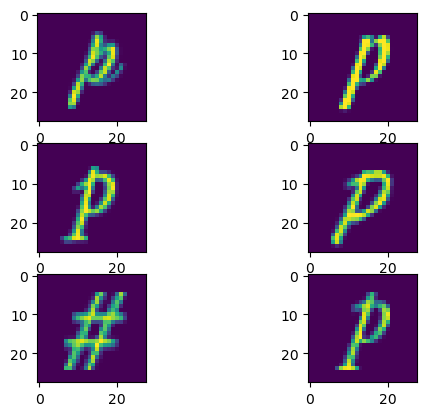

In [17]:
# Finding similar images from the test set using cosine similarity.
test_index = 8
query = encoder(X_test[0:200].to(device=device, dtype=torch.float32))
plot(X_test[test_index][0], title="Query")
NearestNeighbours(query[test_index])